In [ ]:
# !pip install -r requirements.txt
# # Uncomment for colab
# #
# !pip install -q torchdata==0.3.0 torchtext==0.12 spacy==3.2 altair GPUtil
# !python -m spacy download de_core_news_sm
# !python -m spacy download en_core_web_sm

In [ ]:
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import spacy
import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP


# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [ ]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1)

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [ ]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [ ]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"

    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [ ]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."

    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [ ]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [ ]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(
        torch.uint8
    )
    return subsequent_mask == 0

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )

        # 3) "Concat" using a view and apply a final linear.
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(nbatches, -1, self.h * self.d_k)
        )
        del query
        del key
        del value
        return self.linears[-1](x)

In [ ]:
class PositionwiseFeedForward(nn.Module):
    """Implements FFN equation.
        Two convolutions with kernel size 1
    """

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

In [ ]:
def make_model(
    src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1
):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab),
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [ ]:
def inference_test():
    test_model = make_model(11, 11, 2)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)

    for i in range(9):
        out = test_model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()


show_example(run_tests)

![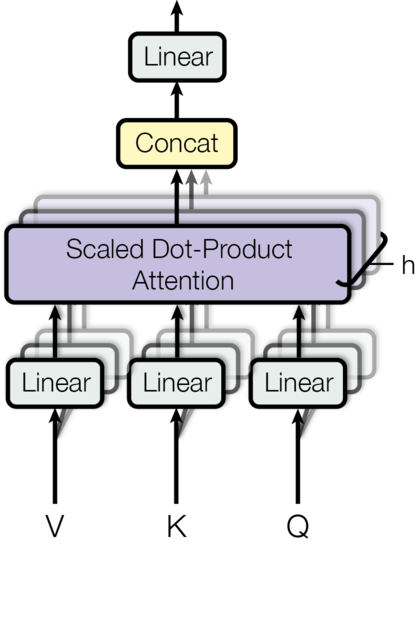]()